## 청진음 모델(add SMOTE Method)

정상 호흡음을 정상 호흡음이라고 판단한 Audio Data(91개)

Wheezing이라고 판단했지만 정상 호흡음 이었던 Audio Data(24개)

정상 호흡음이지만 잡음이 많이 들어간 Audio Data(23개)
#### --> 총 178개의 Audio Data = Healthy

Wheezing을 Wheezing이라고 판단한 Audio Data(74개)

Wheezing을 Wheezing이라고 판단했지만 Wheezing구간을 정확히 맞추지 못한 Audio Data(24개)
#### --> 총 85개의 Audio Data = Wheezing

Wheezing, Healthy data 간 불균형(Imbalance)이 보임.
SMOTE(Syntetic Minority Oversampling Technique) 기법으로 불균형을 해소하고자 한다.

전처리 과정들은 마크다운 없이 진행한다.

In [1]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [2]:
df = pd.read_csv('data/data1.csv')
df.head()

,fname,label
0,0001-1.wav,wheezing
1,0411-2.wav,wheezing
2,0538-4.wav,wheezing
3,0581-2.wav,wheezing
4,0597-4.wav,wheezing


In [3]:
df = df[df['label'].isin(['wheezing','healthy'])]

In [4]:
path = 'data/all_data/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████| 263/263 [00:59<00:00,  4.40it/s]
<ipython-input-4-bd871a4eab45>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_data = np.array(audio_data)


In [5]:
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,audio_waves,samplerate
0,0001-1.wav,wheezing,"[-1.960364e-06, -1.6989543e-06, 2.2033912e-06,...",22050
1,0411-2.wav,wheezing,"[0.0079015065, 0.010698691, 0.0077624833, 0.00...",22050
2,0538-4.wav,wheezing,"[0.017012855, 0.026953325, 0.025314119, 0.0284...",22050
3,0581-2.wav,wheezing,"[0.020541016, 0.030520504, 0.02603743, 0.02776...",22050
4,0597-4.wav,wheezing,"[-0.013913074, -0.0219503, -0.020427886, -0.02...",22050


In [6]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,audio_waves,samplerate,bit_lengths,second_lengths
0,0001-1.wav,wheezing,"[-1.960364e-06, -1.6989543e-06, 2.2033912e-06,...",22050,198648,9.00898
1,0411-2.wav,wheezing,"[0.0079015065, 0.010698691, 0.0077624833, 0.00...",22050,158919,7.207211
2,0538-4.wav,wheezing,"[0.017012855, 0.026953325, 0.025314119, 0.0284...",22050,129490,5.872562
3,0581-2.wav,wheezing,"[0.020541016, 0.030520504, 0.02603743, 0.02776...",22050,164805,7.47415
4,0597-4.wav,wheezing,"[-0.013913074, -0.0219503, -0.020427886, -0.02...",22050,444384,20.153469


In [7]:
df = df[df['second_lengths'] >= 2.0]

In [8]:
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['second_lengths'])
print(min_seconds)

48113
2.1819954648526076


In [9]:
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [10]:
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [11]:
num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 6000/6000 [00:05<00:00, 1007.14it/s]


In [12]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 5986/5986 [00:41<00:00, 145.13it/s]


In [13]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5986, 48113)
(5986, 300, 13)


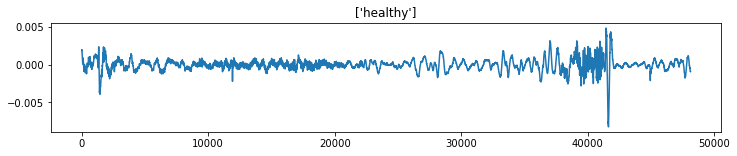

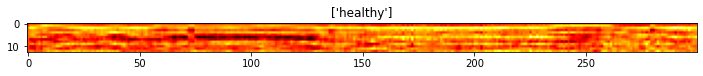

In [14]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

### Pre-processing

In [15]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[1 0 0 ... 0 1 0]


/home/nextgen/anaconda3/envs/kbs_coin/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
label_encoded = label_encoded[:, np.newaxis]
label_encoded

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [17]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
one_hot_encoded

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [18]:
X = mfcc_features
y = one_hot_encoded

In [19]:
X = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
y_train.shape

(4788, 2)

In [21]:
y_train[0:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [22]:
X_train.shape

(4788, 300, 13)

### SMOTE 적용을 위해 X_train의 3d array를 2d array로 reshape했다.

In [24]:
X_train = X_train.reshape(4788, -1)

In [25]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

/home/nextgen/anaconda3/envs/kbs_coin/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [26]:
X_train.shape

(6382, 3900)

### SMOTE 적용 후 다시 Input에 넣기 위한 3d array로 되돌려준다.

In [27]:
X_train = X_train.reshape(6382, 300, -1)

In [28]:
X_train.shape

(6382, 300, 13)

In [29]:
y_train.shape

(6382, 1)

In [30]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train)
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [31]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(6382, 300, 13, 1)
(1198, 300, 13, 1)


In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 13, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 6, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 6, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1843264   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [35]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
200/200 [==============================] - 13s 21ms/step - loss: 0.5103 - acc: 0.7791 - val_loss: 0.3846 - val_acc: 0.8773
Epoch 2/40
200/200 [==============================] - 4s 19ms/step - loss: 0.3513 - acc: 0.8953 - val_loss: 0.3424 - val_acc: 0.8806
Epoch 3/40
200/200 [==============================] - 4s 19ms/step - loss: 0.3228 - acc: 0.8979 - val_loss: 0.3471 - val_acc: 0.8831
Epoch 4/40
200/200 [==============================] - 4s 19ms/step - loss: 0.3187 - acc: 0.8940 - val_loss: 0.3577 - val_acc: 0.8831
Epoch 5/40
200/200 [==============================] - 4s 19ms/step - loss: 0.3235 - acc: 0.8907 - val_loss: 0.3225 - val_acc: 0.8831
Epoch 6/40
200/200 [==============================] - 4s 19ms/step - loss: 0.3007 - acc: 0.8991 - val_loss: 0.3480 - val_acc: 0.8856
Epoch 7/40
200/200 [==============================] - 4s 19ms/step - loss: 0.2851 - acc: 0.9038 - val_loss: 0.3404 - val_acc: 0.8840
Epoch 8/40
200/200 [==============================] - 4s 20ms/step -

### Visualize

loss: 0.17920823395252228
val_loss: 0.332589715719223


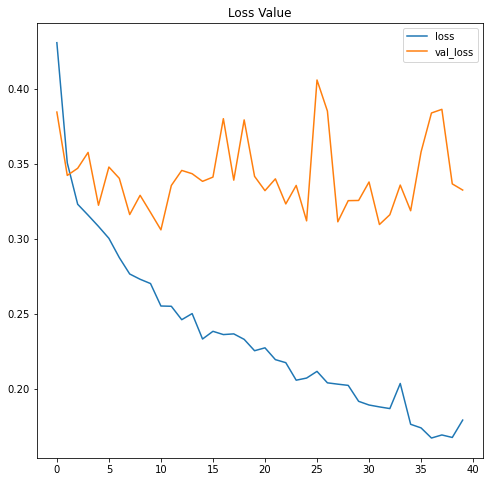

acc: 0.9334064722061157
val_acc: 0.8856427669525146


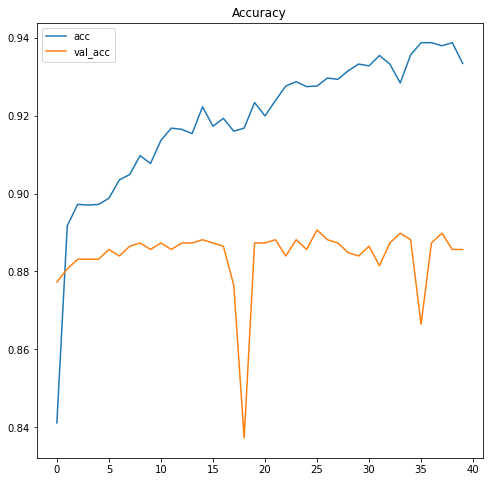

In [36]:
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

### SMOTE 이전의 Pilot Model보다.. 성능이 안좋아졌다.
### 모델좀 바꿔보고 하이퍼파라미터 바꿔보기도 했는데.. 성능이 안좋다.

### 크흠.............
### 다른 기법을 찾아 적용해 보아야겠다..